In [1]:
import numpy as np
import skimage
from skimage import io, transform
import matplotlib.pyplot as plt
import torch
from torch.utils import data
from dataset import PlacesDataset
from data_dicts import Dicts
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam,SGD
from sklearn.metrics import jaccard_similarity_score as jss
from skimage.segmentation import find_boundaries as fb
from unet_model import Unet
from loss_functions import train_loss_function,train_loss_function_variance, val_loss_function

In [2]:
dic=Dicts()
train_files,val_files=dic.get_dicts()

In [3]:
def showimage(image,tor):
    if tor==1:
        image=image.numpy().transpose(1,2,0)
        image=image[:,:,::-1]
    plt.imshow(image)
    plt.show()

In [4]:
train_dataset=PlacesDataset(train_files,augment=0, transforms=True)
val_dataset=PlacesDataset(val_files,augment=0,transforms=True)

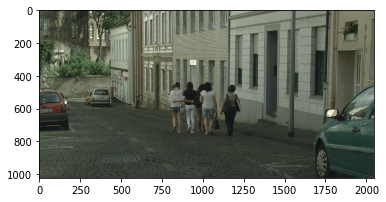

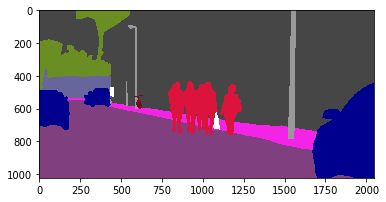

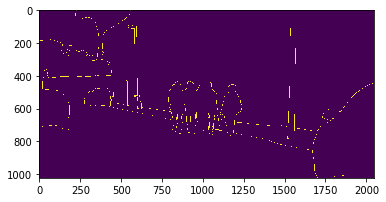

In [5]:
img,label,mask=train_dataset[1500]
showimage(img,1)
plt.imshow(train_dataset.decode_segmap(label.numpy()))
plt.show()
plt.imshow(mask.numpy())
plt.show()

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset,shuffle=True,batch_size=1)
validation_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1)

In [7]:
unet=Unet()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
unet=unet.to(device)
#optimizer=SGD(unet.parameters(),lr=10**(-4))
#optimizer=SGD(unet.parameters(),lr=10**(-4),momentum=0.99,weight_decay=0.0005)
optimizer=Adam(unet.parameters())

cuda


In [8]:
def train(input_image,target_image,masks,optimizer):
    unet.train()
    optimizer.zero_grad()
    #output_image=unet(input_image)
    output_image,output_image_b,output_image_c,output_image_d=unet(input_image)
    loss=train_loss_function_variance(output_image,output_image_b,output_image_c,output_image_d,target_image,masks,2.5)
    #loss=train_loss_function(output_image,target_image,masks)
    loss.backward()
    optimizer.step()
    return loss.item()

In [9]:
def validation(input_image,target_image):
    with torch.no_grad():
        unet.eval()
        output_image=unet(input_image)
       # print(output)
        loss=val_loss_function(output_image,target_image)
        return loss

In [10]:
checkpoint = torch.load('/scratch/ab8084/Unet/saved/model_2.pth')
unet.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
batch = checkpoint['epoch']
tl = checkpoint['tl']
vl = checkpoint['vl']
unet.train()
print('%--Loaded the model--%')

%--Loaded the model__%


In [10]:
tl=[]
vl=[]
benchmark=0
for batch in range(0,10):
    running_loss=0
    for i,inputs in enumerate(train_loader):
        input_image=Variable(inputs[0]).to(device)
        target_image=Variable(inputs[1]).to(device)
        masks=Variable(inputs[2]).to(device)
        loss=train(input_image,target_image,masks,optimizer)
        running_loss+=loss
        tl.append(loss)
        if (i+1)%186==0:
            loss_val=0
            for j,inputs in enumerate(validation_loader):
                input_image=(inputs[0]).to(device)
                target_image=(inputs[1]).to(device)
                loss_val+=validation(input_image,target_image)
            loss_val=loss_val/(j+1)
            vl.append(loss_val)
            print ('Step: {} | Batch: {} | Training loss: {} | Validation IoU: {}'.format(int((i+1)/186), batch+1, running_loss, loss_val))
            running_loss=0
            if(loss_val>benchmark):
                print('%--Saving the model--%')
                torch.save({
                    'step':int((i+1)/186),
                    'epoch': batch+1,
                    'model_state_dict': unet.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'tl': tl,
                    'vl': vl
                    }, '/scratch/ab8084/Unet/saved/model_1024.pth')
                benchmark=loss_val
            
            

Step: 1 | Batch: 1 | Training loss: 368.19089710712433 | Validation IoU: 0.4353220195770264
%--Saving the model--%


KeyboardInterrupt: 

In [11]:
np.amax(vl)

0.8298396453857422

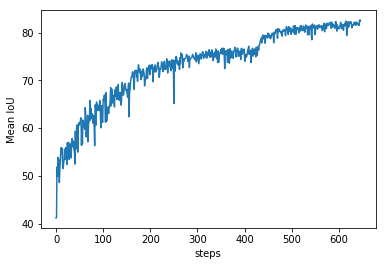

In [17]:
plt.plot(range(len(vl)),np.array(vl)*100)
plt.xlabel('steps')
plt.ylabel('Mean IoU')
plt.show()

In [12]:
batch

45

In [13]:
fb(target_image[0].cpu().numpy(),mode='outer').astype(np.uint8)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=uint8)

In [12]:
torch.save({
        'step':int((i+1)/93),
        'epoch': batch+1,
        'model_state_dict': unet.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'tl': tl,
        'vl': vl
        }, '/scratch/ab8084/Unet/saved/model_2.pth')